# Crop Segmentation

This notebook is a part of the [Crop Segmentation and Classification](crop-segmentation-and-classification.ipynb) notebook project. In this notebook, we compare methods for segmentation of a Planet image into crops.

The sections are:
1. [Crop Datasets to AOI](#crop)
2. [Visualize Ground Truth Data over Image](#visualize)
3. [Segment Image](#segment)

### Usage Notes

This notebook was developed in a Docker container. This [Dockerfile](Dockerfile) was used to build the image.

In [26]:
# Notebook dependencies
from __future__ import print_function

import copy
from collections import namedtuple
from functools import partial
import json
import os
import subprocess
from xml.dom import minidom

import ipyleaflet as ipyl
import ipywidgets as ipyw
from IPython.display import display, Image
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pyproj
import rasterio
from shapely.geometry import shape, mapping
from shapely.geometry.geo import box
from shapely.ops import transform
from skimage import segmentation

%matplotlib inline

In [2]:
# These datasets are created in identify-datasets notebook
data_folder = 'data'
pl_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS.tif')
assert os.path.isfile(pl_filename)

pl_metadata_filename = os.path.join(data_folder, '20160831_180231_0e0e_3B_AnalyticMS_metadata.xml')
assert os.path.isfile(pl_metadata_filename)

aoi_filename = os.path.join(data_folder, 'aoi.geojson')
assert os.path.isfile(aoi_filename)

ground_truth_filename = os.path.join(data_folder, 'ground-truth.geojson')
assert os.path.isfile(ground_truth_filename)

<a id='crop'></a>

## Crop Datasets to AOI

Here we crop the Planet image and the ground truth data to the AOI and visualize the RGB bands.

### Crop image

In [3]:
# create clipped file name
filename, extension = pl_filename.rsplit('.', 1)
cropped_filename = filename + '_cropped.' + extension
print(cropped_filename)

data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif


In [4]:
commands = ['gdalwarp',
            '-cutline', aoi_filename,
            '-crop_to_cutline',
            '-overwrite',
            pl_filename,
            cropped_filename]
print(' '.join(commands))
subprocess.check_call(commands)
assert os.path.isfile(cropped_filename)

gdalwarp -cutline data/aoi.geojson -crop_to_cutline -overwrite data/20160831_180231_0e0e_3B_AnalyticMS.tif data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif


### Visualize Cropped Image

Utilities for working with an image with a mask

In [5]:
# NOTE: Not sure a namedtuple is what we want long-term. It is used now because:
# memory footprint is smaller than a masked ndarray (where the same mask is repeated across all bands)
# response is faster than rasterio read(), which appears to read from the file vs. caching

# Saves the image bands and image mask separately
# Bands is a 16-bit 3darray representing band pixels
# Mask is a boolean 2d array identifying nodata pixels
MaskedImage = namedtuple('MaskedImage', 'bands, mask')

def load_masked_image(filename):
    with rasterio.open(filename) as src:
        b, g, r, nir = src.read()
        mask = src.read_masks(1) == 0 # 0 value means the pixel is masked
        return MaskedImage(bands=np.dstack([r, g, b, nir]), mask=mask)
# img = load_masked_image(image_filename)
# del img

def create_masked_bands(masked_image):
    # recast 2d mask to 3d, repeating across 3rd axis
    mask = np.broadcast_to(np.atleast_3d(masked_image.mask),
                           masked_image.bands.shape)
    return ma.masked_array(masked_image.bands, mask)
# masked_bands = create_masked_bands(load_masked_image(image_filename))
# del masked_bands
    
def mask_to_alpha(bands):
    band = np.atleast_3d(bands)[...,0]
    alpha = np.zeros_like(band)
    alpha[~band.mask] = 1
    return alpha

def add_alpha_mask(bands):
    return np.dstack([bands, mask_to_alpha(bands)])

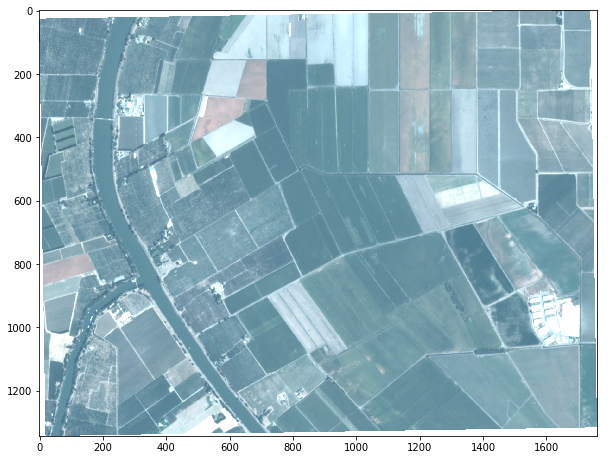

In [6]:
def linear_scale(ndarray, old_min, old_max, new_min, new_max):
    """Linear scale from old_min to new_min, old_max to new_max.
    
    Values below min/max are allowed in input and output.
    Min/Max values are two data points that are used in the linear scaling.
    """
    #https://en.wikipedia.org/wiki/Normalization_(image_processing)
    return (ndarray - old_min)*(new_max - new_min)/(old_max - old_min) + new_min
# print(linear_scale(np.array([1,2,10,100,256,2560, 2660]), 2, 2560, 0, 256))

def bands_to_display(masked_bands):
    """Converts masked bands to a 3-band rgb, normalized array for display."""
    rgb_bands = masked_bands[:,:,:3]

    old_min = np.percentile(rgb_bands, 2)
    old_max = np.percentile(rgb_bands, 98)
    new_min = 0
    new_max = 1
    scaled = linear_scale(rgb_bands.astype(np.double),
                          old_min, old_max, new_min, new_max)
    clipped = np.clip(scaled, new_min, new_max)
    return add_alpha_mask(clipped) 

def image_to_display(masked_image):
    """Converts the masked image to a 3-band rgb, normalized array for display."""
    return bands_to_display(create_masked_bands(masked_image))

plt.figure(1,figsize=(10,10))
plt.imshow(image_to_display(load_masked_image(cropped_filename)))

### Crop and Project Ground Truth Data

In [7]:
# load ground truth data
with open(ground_truth_filename, 'r') as f:
    ground_truth_data = json.load(f)
print(len(ground_truth_data))

7429


In [8]:
# load aoi and store as shapely shape
with open(aoi_filename, 'r') as f:
    aoi = shape(json.load(f)['geometry'])
print(aoi)

POLYGON ((-121.584609746933 38.29170496647727, -121.584609746933 38.32726528409606, -121.5248715877533 38.32726528409606, -121.5248715877533 38.29170496647727, -121.584609746933 38.29170496647727))


In [9]:
# define crop function
def crop_features_to_aoi(features):
    cropped_features = []
    for f in features:
        if shape(f['geometry']).within(aoi):
            cropped_features.append(copy.deepcopy(f))
        elif shape(f['geometry']).intersects(aoi):
            # 'cut' features at the aoi boundary by the aoi
            new_f = copy.deepcopy(f)
            new_f['geometry'] = mapping(shape(f['geometry']).intersection(aoi))
            cropped_features.append(new_f)
    return cropped_features
    
print(len(crop_features_to_aoi(ground_truth_data)))

221


### Project Ground Truth Data

Ground truth data is stored as geojson, which only supports [EPSG:4326](http://spatialreference.org/ref/epsg/4326/). This must be projected to the Planet image coordinate system.

In [10]:
# source projection is WGS84 CRS
src_proj = 'epsg:4326'

In [11]:
# What is the coordinate reference system for the image?
with rasterio.open(cropped_filename) as img:
    dst_proj = img.crs['init']
print(dst_proj)

epsg:32610


In [12]:
# define projection
# from shapely [docs](http://toblerity.org/shapely/manual.html#shapely.ops.transform)
project_to_pl_crs = partial(
    pyproj.transform,
    pyproj.Proj(init=src_proj),
    pyproj.Proj(init=dst_proj))

def project_feature(feat):
    g1 = shape(feat['geometry'])
    g2 = transform(project_to_pl_crs, g1)
    proj_feat = copy.deepcopy(feat)
    proj_feat['geometry'] = mapping(g2)
    return proj_feat

def project_features(features):
    return [project_feature(f) for f in features]

In [13]:
projected_ground_truth_data = project_features(crop_features_to_aoi(ground_truth_data))
print(len(projected_ground_truth_data))

221


<a id='visualize'></a>

## Visualize Ground Truth Data over Image

Define Layer for cropped Planet scene

First we  project the cropped Planet scene to WGS84 for showing on the map. Then we adjust the scene for display and save as jpeg.

In [14]:
img = rasterio.open(cropped_filename)
src_proj = img.crs['init']
print(src_proj)
img_bounds = box(*img.bounds)
del img

dst_proj = 'epsg:4326' #WGS84
print(dst_proj)

epsg:32610
epsg:4326


In [15]:
# Create projected version of cropped image
projected_filename = 'data/proj.tif'
commands = ['gdalwarp',
            '-overwrite',
            '-s_srs', src_proj,
            '-t_srs', dst_proj,
            cropped_filename,
            projected_filename]
print(' '.join(commands))
subprocess.check_call(commands)

gdalwarp -overwrite -s_srs epsg:32610 -t_srs epsg:4326 data/20160831_180231_0e0e_3B_AnalyticMS_cropped.tif data/proj.tif


0

Save 8bit display version of cropped Planet Scene as JPG

Leaflet appears to support local files if they are jpg ([src](https://gis.stackexchange.com/questions/82936/how-i-can-load-tilelayer-in-leaflet-framework-using-local-tiles))


In [17]:
img = image_to_display(load_masked_image(projected_filename))

# save image, delete before saving if it already exists
display_image = 'data/proj_img2.jpg'
if(os.path.isfile(display_image)): os.remove(display_image)
matplotlib.image.imsave(display_image, img)

In [18]:
display(Image(url=display_image))

In [19]:
# Define the bounds for display of the image on the map
img = rasterio.open(projected_filename)
(minx, miny, maxx, maxy) = img.bounds
del img

sw = [miny, minx]
ne = [maxy, maxx]
print([sw, ne])

[[38.29095983064804, -121.58530068766473], [38.328001399320975, -121.52415672841694]]


In [20]:
# Create image layer
local_img_url = display_image
image_layer = ipyl.ImageOverlay(url=local_img_url, bounds=[sw, ne])

Define Layer for ground truth data

In [21]:
# Assign colors to classes

# Class ids from dwr_survey/09legend.pdf
agg_classes = ['G', 'R', 'F', 'P', 'T', 'D', 'C', 'V']

# colors determined using [colorbrewer2.org](http://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3)
colors = ['#ffffd9','#edf8b1','#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
class_colors = dict((a,c) for a,c in zip(agg_classes, colors))
def get_color(cls):
    return class_colors[cls]

In [22]:
feature_collection = {
    "type": "FeatureCollection",
    "features": crop_features_to_aoi(ground_truth_data)
}

for f in feature_collection['features']:
    feature_color = get_color(f['properties']['CLASS1'])
    f['properties']['style'] = {
        'color': 'black',
        'weight': 1,
        'fillColor': feature_color,
        'fillOpacity': 0.1}

feature_layer = ipyl.GeoJSON(data=feature_collection)

In [23]:
# display bounds box
aoi_feature = {
    'geometry':mapping(aoi),
    "properties":{
            'style':{'color': 'red', 'fillOpacity': 0.0, 'weight': 1}},
    'type':u"Feature"}

aoi_layer = ipyl.GeoJSON(data=aoi_feature)

In [24]:
zoom = 13
center = [38.30933576918588, -121.55410766601564] # lat/lon
map_tiles = ipyl.TileLayer(url='http://{s}.basemaps.cartocdn.com/light_all/{z}/{x}/{y}.png')

data_map = ipyl.Map(
    center=center, 
    zoom=zoom,
    default_tiles = map_tiles
)

data_map.add_layer(image_layer)
data_map.add_layer(feature_layer)
data_map.add_layer(aoi_layer)

data_map
# Display
ipyw.VBox([data_map])

Awesome! The data looks nicely registered to the imagery and the crop outlines don't appear to have changed much over the years. We can use the ground truth data for our crop segmentation study.

Although we converted the scene to WGS84 for display on the map, we want to perform analysis in the unprojected version, which is in a UTM coordinate system.

<a id='segment'></a>

## Segment Image

#### Convert to TOA reflectance

Converting from TOA radiance to TOA reflectance normalizes the values to [0,1], which is required for the image processing algorithms. It also allows for comparison accross images.

The code for reading reflectance coefficients from metadata is pulled from [NDVI notebook](https://github.com/planetlabs/notebooks/blob/master/jupyter-notebooks/ndvi/ndvi_planetscope.ipynb)

In [27]:
xmldoc = minidom.parse(pl_metadata_filename)
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)

print(coeffs)

{1: 2.22720534111e-05, 2: 2.32869411017e-05, 3: 2.6177702949e-05, 4: 3.85793404296e-05}


In [29]:
def to_reflectance(masked_bands, coeffs):
    refl_bands = masked_bands.astype(np.double)
    for i in range(refl_bands.shape[2]):
        refl_bands[:,:,i] = refl_bands[:,:,i] * coeffs[i+1]
    return refl_bands

masked_bands = create_masked_bands(load_masked_image(cropped_filename))
refl_bands = to_reflectance(masked_bands, coeffs)
print(refl_bands.min())
print(refl_bands.max())

0.0472167532315
0.63637995869


Display reflectance bands

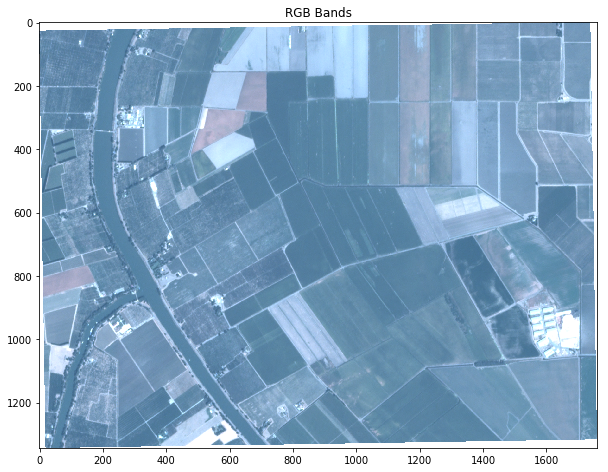

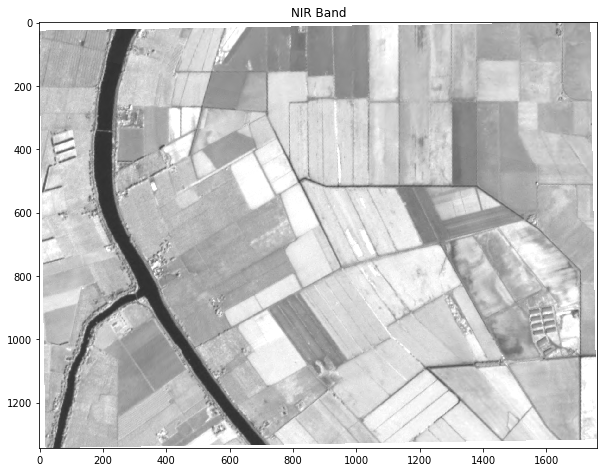

In [30]:
figsize = (10, 10)

rgb_bands = refl_bands[...,:3]
plt.figure(1,figsize=figsize)
plt.imshow(bands_to_display(rgb_bands))
plt.title('RGB Bands')

# repeat NIR band 3 times to get greyscale in RGB
nir_bands = refl_bands[:,:,(3,3,3)]
plt.figure(2, figsize=figsize)
plt.imshow(bands_to_display(nir_bands))
plt.title('NIR Band')

### SLIC Segmentation

SLIC segmentation clusters pixels in the (r,g,b) x (x,y,z) space. It requires 3 spectral bands. We will consider RGB and NIR separately.

In the results we see that the water features stand out more in the NIR image but both don't do a great job of segmenting the crops.

In [31]:
def normalize(masked_bands):
    old_min = np.percentile(masked_bands, 2)
    old_max = np.percentile(masked_bands, 98)
    new_min = 0
    new_max = 1
    scaled = linear_scale(masked_bands.astype(np.double),
                          old_min, old_max, new_min, new_max)
    return np.clip(scaled, new_min, new_max)

In [32]:
enforce_connectivity=True
slic_rgb_img = segmentation.slic(normalize(rgb_bands), enforce_connectivity=enforce_connectivity)
slic_nir_img = segmentation.slic(normalize(nir_bands), enforce_connectivity=enforce_connectivity)

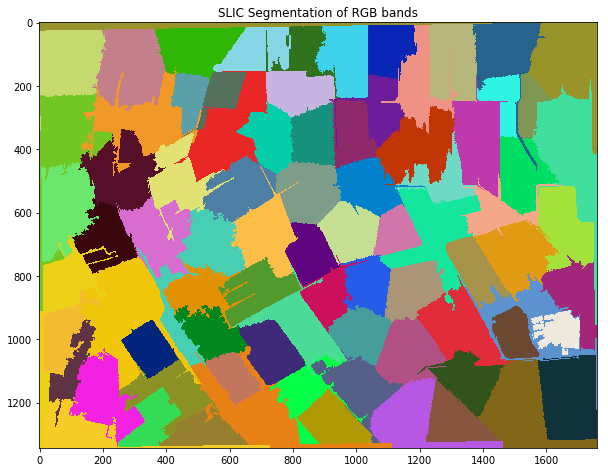

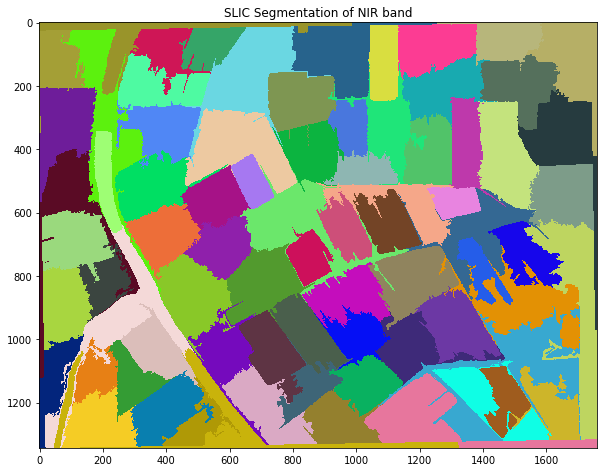

In [33]:
# https://gist.github.com/jgomezdans/402500
cmap = matplotlib.colors.ListedColormap(np.random.rand(256,3))

plt.figure(1,figsize=(10,10))
plt.imshow(slic_rgb_img, cmap=cmap)
plt.title('SLIC Segmentation of RGB bands')

plt.figure(2,figsize=(10,10))
plt.imshow(slic_nir_img, cmap=cmap)
plt.title('SLIC Segmentation of NIR band')